# ASUM

In [40]:
import re
import json

import numpy as np
import pandas as pd

from itertools import chain
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from reviews.config import (
    processed_data_dir,
    asum_model_path,
    asum_input_dir,
    asum_output_dir,
    data_dir,
)
from reviews.utils import flat_sentence_tokens
from reviews.models import ASUM

from sklearn.metrics import f1_score

## Generate Input Data

In [41]:
NORM = "lemmatization"  # stemming, lemmatization
FIELD = "text"  # text, text+summary

In [42]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}.json.gz")

too_long = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) > 50)
reviews_df.loc[too_long, "tokens"] = "[]"

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")

Too Long Reviews: 10.15%


In [43]:
# vocabulary
tokens = flat_sentence_tokens(reviews_df["tokens"])
vocabulary = dict((e, i) for i, e in enumerate(set(tokens)))

vocabs = set(vocabulary.keys())

with open(asum_input_dir / "WordList.txt", "w") as f:
    f.write("\n".join(vocabs))

In [44]:
# docs
with open(asum_input_dir / "BagOfSentences.txt", "w") as f:
    lines = []
    for doc in reviews_df["tokens"]:
        n = len(doc)
        lines.append(str(n))

        for tokens in doc:
            indexes = " ".join([str(vocabulary[t]) for t in tokens])
            lines.append(indexes)

    f.write("\n".join(lines))

In [45]:
# sentiment words
with open(data_dir / "sentiwords.json", "r") as f:
    senti_words = json.load(f)

    normalized = senti_words[NORM]

    pos_words = normalized["positive"]
    neg_words = normalized["negative"]

with open(data_dir / "asum" / "SentiWords-0.txt", "w") as f:
    f.write("\n".join(pos_words))

with open(data_dir / "asum" / "SentiWords-1.txt", "w") as f:
    f.write("\n".join(neg_words))

## Run

In [46]:
n_runs = 10
n_topics = 30
iterations = 1000

alpha = 0.1  # 50 / n_topics # 0.1
beta = [0.001, 0.1, 0]
gamma = [1, 1]

In [47]:

metrics = []
for run in range(n_runs):
    # train the model
    model = ASUM(asum_model_path, asum_input_dir, asum_output_dir)
    model.estimate(alpha, beta, gamma, n_topics, iterations)

    # compute metrics
    filename_prefix = f"STO2-T{n_topics}-S2(2)-A{alpha}-B{','.join([f'{float(x)}' for x in beta])}-G{','.join([f'{float(x):.1f}' for x in gamma])}-I{iterations}"
    pi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Pi.csv", header=None)
    doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
    reviews_df["sentiment"] = doc_sentiment

    gt = reviews_df[reviews_df["overall"] != 3]["overall"]
    pred = reviews_df[reviews_df["overall"] != 3]["sentiment"]

    y_true = gt.apply(lambda x: "negative" if x < 3 else "positive").astype("category")
    y_pred = pred.astype("category")

    metrics.append([run, n_topics, f1_score(y_true, y_pred, average="macro"),
        f1_score(y_true, y_pred, average="weighted"),
        f1_score(y_true, y_pred, average="micro"),
    ])

metrics_df = pd.DataFrame(metrics, columns=['run', 'n_topics', 'f1_macro', 'f1_weighted', 'f1_micro'])
metrics_df.to_csv(asum_output_dir / f'metrics_asum_{n_topics}_{FIELD}_{NORM}.csv')
metrics_df

Documents: 21951
Unique Words: 14062
Documents: 21951
Unique Words: 14062
Topics: 1
Sentiments: 2 (dictionary: 2)
Alpha: 0.1
Beta: 
0.001 0.1 0 
Gamma: 1 1 
Iterations: 1000
Threads: 3
Input Dir: /home/ubuntu/Desktop/amazon-reviews/data/asum
Dictionary Dir: /home/ubuntu/Desktop/amazon-reviews/data/asum
Output Dir: /home/ubuntu/Desktop/amazon-reviews/output/asum
Too Long Sentences: 0
Gibbs sampling started (Iterations: 1000, Threads: 3)
  - Iteration 0
positive/24/0/ perfect/702/0/ enjoy/7/0/ good/172/0/ comfortable/7/0/ correct/4/0/ fun/1/0/ awesome/3/0/ impressive/1/0/ attractive/4/0/ happy/1/0/ best/1/0/ nice/4/0/ thank/1/0/ satisfied/60/0/ amazing/1/0/ favorite/70/0/ excellent/1/0/ superior/0/0/ glad/1/0/ fantastic/20/0/ great/2/0/ fortunate/1/0/ worth/324/0/ recommend/913/0/ love/671/0/ 
not_like/0/235/ annoying/0/17/ nasty/0/3/ upset/0/7/ disappointed/0/40/ unfortunate/0/3/ negative/0/33/ complain/0/1/ worthless/0/2/ sorry/0/2/ not_good/0/1/ not_recommend/0/1/ poor/0/2/ hate/0/1/ 

## Analysis

In [10]:
filename_prefix = f"STO2-T{n_topics}-S2(2)-A{alpha}-B{','.join([f'{float(x)}' for x in beta])}-G{','.join([f'{float(x):.1f}' for x in gamma])}-I{iterations}"
pi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Pi.csv", header=None)
doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
reviews_df["sentiment"] = doc_sentiment

In [11]:
gt = reviews_df[reviews_df["overall"] != 3]["overall"]
pred = reviews_df[reviews_df["overall"] != 3]["sentiment"]

y_true = gt.apply(lambda x: "negative" if x < 3 else "positive").astype("category")
y_pred = pred.astype("category")

print(y_true.value_counts())

pd.crosstab(y_true, y_pred)

positive    19149
negative     1684
Name: overall, dtype: int64


sentiment,negative,positive
overall,,
negative,1308,376
positive,7814,11335


In [12]:
pd.DataFrame({
    "f1_score": [
        f1_score(y_true, y_pred, average="macro"),
        f1_score(y_true, y_pred, average="weighted"),
        f1_score(y_true, y_pred, average="micro"),
    ]},
    index=["macro", "weighted", "accuracy"],
)

,f1_score
macro,0.488348
weighted,0.694796
accuracy,0.606874


In [13]:
df = pd.read_csv(asum_output_dir / f"{filename_prefix}-ProbWords.csv")


def map_topic_sentiment(column_name):
    if "Unnamed" in column_name:
        return None

    values = column_name.split("-")
    return {
        "sentiment": int(values[0][1]),
        "topic": int(values[1][1:]),
        "colname": column_name,
    }


columns = df.columns.map(map_topic_sentiment)
columns

Index([  {'sentiment': 0, 'topic': 0, 'colname': 'S0-T0'},
         {'sentiment': 0, 'topic': 1, 'colname': 'S0-T1'},
         {'sentiment': 0, 'topic': 2, 'colname': 'S0-T2'},
         {'sentiment': 0, 'topic': 3, 'colname': 'S0-T3'},
         {'sentiment': 0, 'topic': 4, 'colname': 'S0-T4'},
         {'sentiment': 0, 'topic': 5, 'colname': 'S0-T5'},
         {'sentiment': 0, 'topic': 6, 'colname': 'S0-T6'},
         {'sentiment': 0, 'topic': 7, 'colname': 'S0-T7'},
         {'sentiment': 0, 'topic': 8, 'colname': 'S0-T8'},
         {'sentiment': 0, 'topic': 9, 'colname': 'S0-T9'},
       {'sentiment': 0, 'topic': 10, 'colname': 'S0-T10'},
       {'sentiment': 0, 'topic': 11, 'colname': 'S0-T11'},
       {'sentiment': 0, 'topic': 12, 'colname': 'S0-T12'},
       {'sentiment': 0, 'topic': 13, 'colname': 'S0-T13'},
       {'sentiment': 0, 'topic': 14, 'colname': 'S0-T14'},
       {'sentiment': 0, 'topic': 15, 'colname': 'S0-T15'},
       {'sentiment': 0, 'topic': 16, 'colname': 'S0-T16'

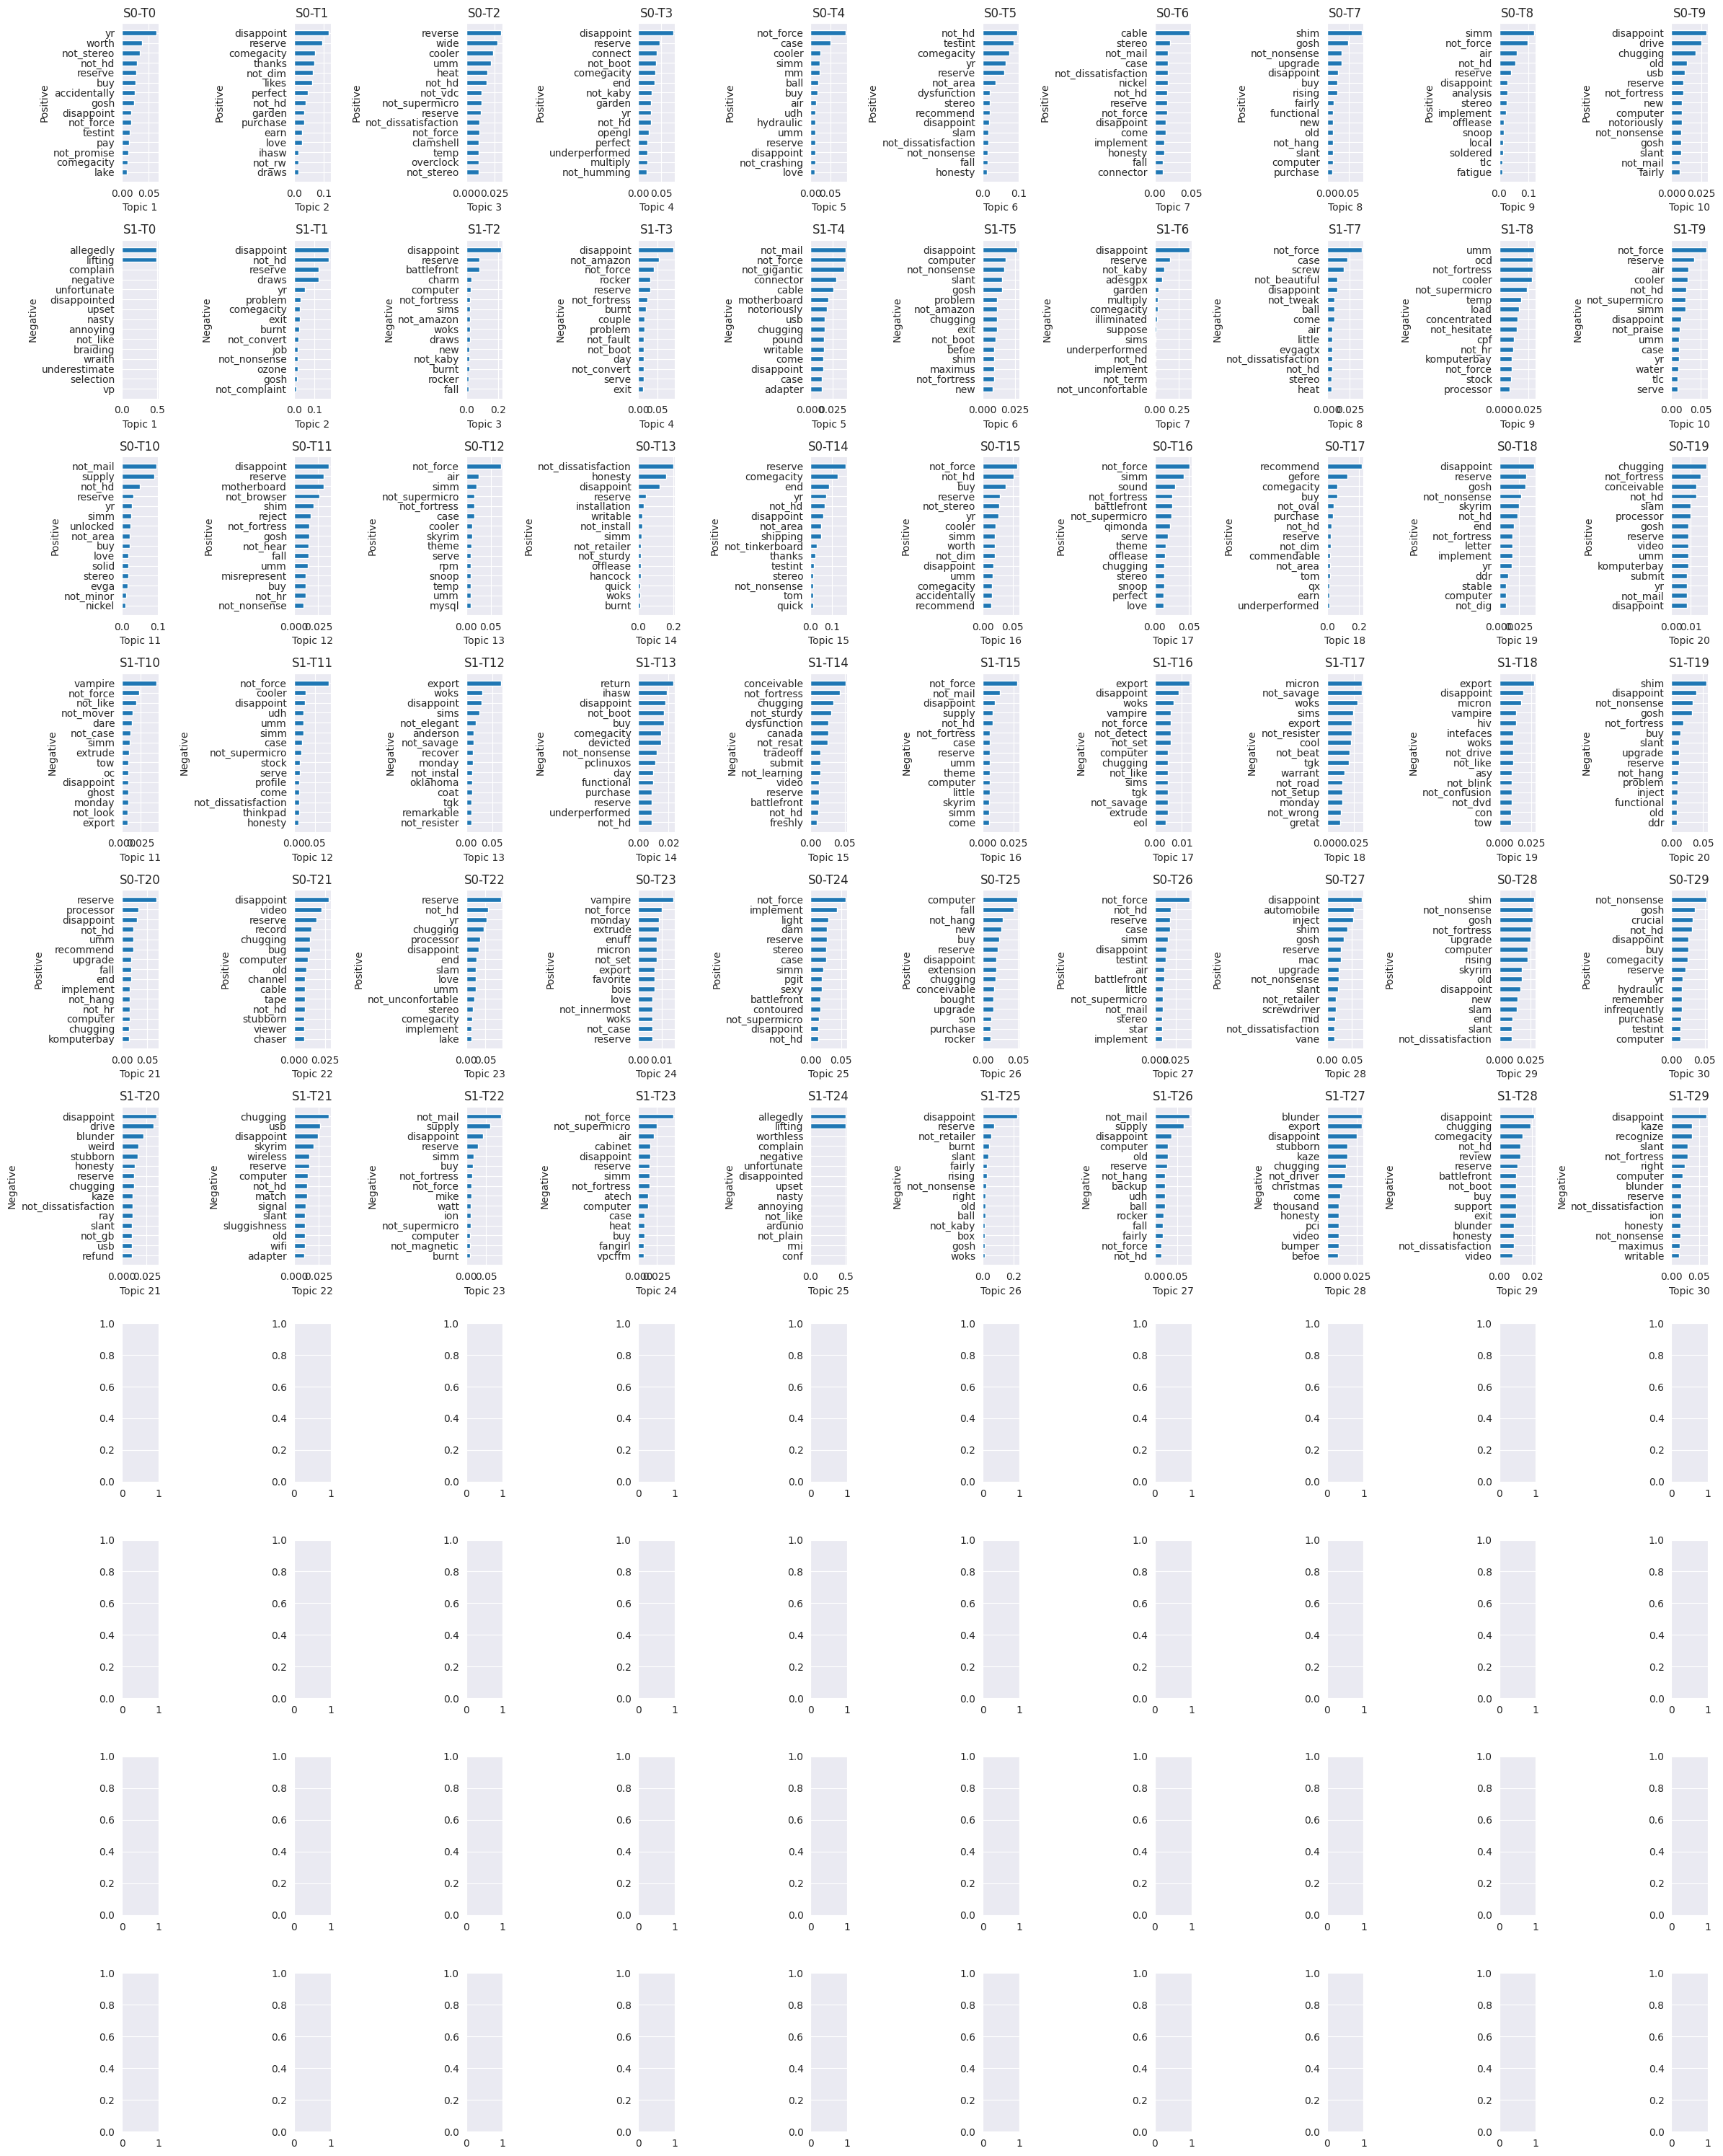

In [14]:
def get_word_weight(text):
    match = re.match("(\w+)\s+\((.*?)\)", text)
    word, weight = match.groups()
    return word, float(weight)


n_topics = 50
n_top_words = 15

total_df = pd.DataFrame()

fig, axes = plt.subplots(int(n_topics / 10 * 2), 10, figsize=(24, 30))

for idx, item in enumerate(columns):
    if item is None:
        continue

    ax = axes[
        int(int(item["topic"] / 10) * 2 + item["sentiment"]), int(item["topic"] % 10)
    ]
    words = df[item["colname"]][:n_top_words]
    weights = list(map(list, zip(*words.map(get_word_weight))))

    weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
    weights.sort_values("weights", inplace=True)

    w = weights.copy()
    w["colname"] = item["colname"]
    total_df = pd.concat((total_df, w))

    ax.barh(weights["names"], weights["weights"], height=0.5)
    ax.set_title(item["colname"])

    # if idx > n_topics - 1:
    ax.set_xlabel(f"Topic {item['topic'] + 1}")

    # if idx == 0 or idx == n_topics:
    # if int(int(item["topic"] / 10) * 2 + item["sentiment"]) % 2 == 0:
    ax.set_ylabel("Positive" if item["sentiment"] == 0 else "Negative")

fig.tight_layout()

In [15]:
# create embeddings

vocab = list(total_df["names"].unique())
word_weights = total_df.groupby("colname")[["names", "weights"]].apply(
    lambda x: dict(zip(x["names"], x["weights"]))
)
word_weights = word_weights.reset_index()


def get_embedding(weights, vocab):
    return np.array([weights.get(v, 0) for v in vocab])


embeddings = {
    ww["colname"]: get_embedding(ww[0], vocab) for i, ww in word_weights.iterrows()
}

In [16]:
# from sklearn.cluster import AgglomerativeClustering
#
# k = AgglomerativeClustering(affinity="cosine", linkage="complete", n_clusters=None, distance_threshold=0.9)
# k.fit(list(embeddings.values()))
#
# clusters = list(zip(list(embeddings.keys()), list(k.labels_)))
# clusters = pd.DataFrame(clusters, columns=["colname", "cluster"])
# clusters.groupby("cluster")["colname"].aggregate(list)

<AxesSubplot: xlabel='value', ylabel='word'>

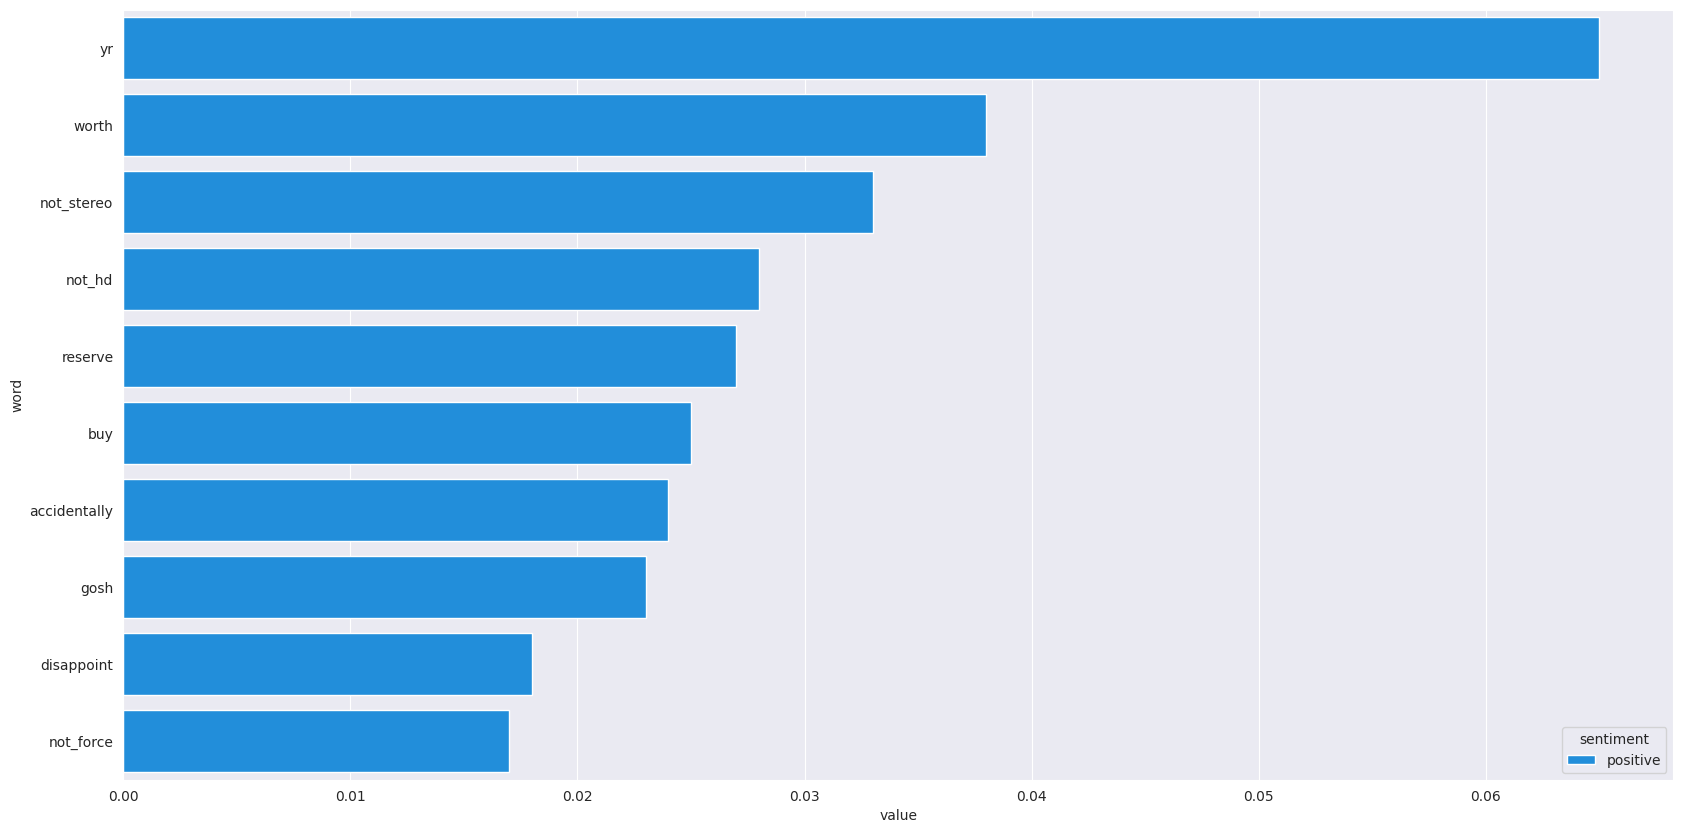

In [17]:
import seaborn as sns

df1 = pd.DataFrame(
    list(df["S0-T0"].apply(get_word_weight)), columns=["word", "positive"]
)
df2 = pd.DataFrame(
    list(df["S1-T0"].apply(get_word_weight)), columns=["word", "negative"]
)

df_tot = pd.merge(df1, df2, on="word", how="left")
df_tot.sort_values(by="positive", ascending=False, inplace=True)
df_tot = df_tot[:10]

df_tot.set_index("word", inplace=True)
df_tot = df_tot.rename_axis(columns=["sentiment"]).stack().rename("value")
df_tot = df_tot.reset_index()

df_tot.sort_values(by="value", ascending=False, inplace=True)
df_tot = df_tot[:20]

fig = plt.figure(figsize=(20, 10))
sns.barplot(
    y=df_tot["word"],
    x=df_tot["value"],
    hue=df_tot["sentiment"],
    dodge=True,
    palette=sns.color_palette("terrain"),
)

<AxesSubplot: ylabel='sentiment'>

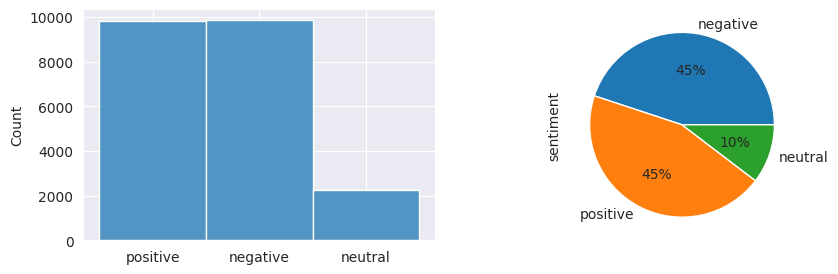

In [18]:
from matplotlib import colors
import seaborn as sns

pi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Pi.csv", header=None)

doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
doc_sentiment.loc[pi_df[0] == 0.5] = "neutral"

reviews_df["sentiment"] = doc_sentiment

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(x=doc_sentiment, ax=axes[0])

counts = doc_sentiment.value_counts()
counts.plot(
    ax=axes[1],
    kind="pie",
    ylabel="sentiment",
    # colors=sns.color_palette("pastel")[0:7],
    autopct="%.0f%%",
)

In [19]:
theta_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Theta.csv")
theta_df.drop(columns=[f"Unnamed: {n_topics * 2}"], inplace=True)

mask = theta_df >= 0.01
mask = mask.apply(lambda x: list(mask.columns[x]), axis=1)

reviews_df["topics"] = mask.apply(lambda x: list(map(map_topic_sentiment, x)))

KeyError: "['Unnamed: 100'] not found in axis"

In [ ]:
reviews_df.to_json(asum_output_dir / "topics.json", orient="records")

In [ ]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
phi_df.sort_values(by="S1-T1", ascending=False, inplace=True)
phi_df

### WordClouds by Topic
- most common words per topic (positive, negative)

In [ ]:
wc = WordCloud(height=400, width=800)
wc.generate_from_frequencies(
    dict(zip(phi_df["Unnamed: 0"].values, phi_df["S0-T4"].values))
)
wc.to_image()

In [ ]:
wc.generate_from_frequencies(
    dict(zip(phi_df["Unnamed: 0"].values, phi_df["S1-T4"].values))
)
wc.to_image()

In [ ]:
theta_df

In [ ]:
pi_df

In [ ]:
phi_df.sort_values("S1-T1", ascending=False)

In [ ]:
from scipy.spatial.distance import cosine

nuova_lista = []
for t1 in range(0, n_topics):
    col1 = f"S0-T{t1}"
    for t2 in range(0, n_topics):
        if t1 <= t2:
            col2 = f"S1-T{t2}"
            c = cosine(phi_df[col1], phi_df[col2])
            if c > 0.99:
                print(col1, col2, c)
                nuova_lista.append((col1, col2))

                min1 = phi_df[col1].sort_values(ascending=False)[:30].min()
                min2 = phi_df[col2].sort_values(ascending=False)[:30].min()
                min_prob = 0.001  # min(min1, min2)
                print(min_prob)

                cond1 = phi_df[col1] >= min_prob
                cond2 = phi_df[col2] >= min_prob

                print(
                    "Common:", ", ".join(list(phi_df.loc[cond1 & cond2]["Unnamed: 0"]))
                )
                print(
                    "Positive:",
                    ", ".join(list(phi_df.loc[cond1 & (~cond2)]["Unnamed: 0"])),
                )
                print(
                    "Negative:",
                    ", ".join(list(phi_df.loc[(~cond1) & cond2]["Unnamed: 0"])),
                )
                print("\n")

In [ ]:
nuova_lista

In [ ]:
total_df

In [ ]:
count = Counter()

for x in reviews_df["topics"].values:
    topics = set(["T" + str(y["topic"]) for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
topics_count["topic"] = topics_count["topic"].astype("category")

order = topics_count.sort_values(by="count", ascending=False).topic
fig = plt.figure(figsize=(8, 5))
ax = sns.barplot(
    y=topics_count["topic"], x=topics_count["count"], order=order, orient="h"
)
ax.set_title("Topics")
fig.tight_layout()

#### Filtrare i topic-sentiment classificando il sentiment

- T1-S0: 34, T1-S1: 56 ---> S1
- T1-S0: 74, T1-S1: 21 ---> S0
- T1-S0: 67, T1-S1: 67 ---> S2 (neutral?)

In [ ]:
from matplotlib.pyplot import title

pos_count = Counter()
neg_count = Counter()

for x in reviews_df["topics"].values:
    pos_topics = set(["T" + str(st["topic"]) for st in x if st["sentiment"] == 0])
    neg_topics = set(["T" + str(st["topic"]) for st in x if st["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)
st_counts = st_counts.iloc[[int(o[1]) for o in order][::-1]]

fig, ax = plt.subplots(figsize=(10, 7))
st_counts.plot(
    kind="barh", stacked=True, color=["red", "green"], ax=ax, title="Topics Sentiment"
)

pass

### topic sentiment over time

In [ ]:
timestamps = list(set(reviews_df["timestamp"]))  # discretizzare per anni
count = Counter()

for x in reviews_df["topics"].values:
    for t in timestamps:
        topics = set(["T" + str(y["topic"]) + str(t) for y in x])
        count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])

In [ ]:
len(timestamps)

### positive sentiment over time

In [ ]:
X = reviews_df.copy()
X = X.loc[X["sentiment"] == "positive"]
fig = plt.figure(figsize=(20, 4))
sns.histplot(x=X["timestamp"], hue=X["sentiment"])

### negative sentiment over time

In [ ]:
X = reviews_df.copy()
X = X.loc[X["sentiment"] == "negative"]
fig = plt.figure(figsize=(20, 4))
sns.histplot(x=X["timestamp"], hue=X["sentiment"])

### top 30 brands sentiment 

In [ ]:
X = reviews_df.copy()

# take only top 30 most common brands
most_common_brands = pd.DataFrame(Counter(X["brand"]).most_common(30))
X = X.loc[X["brand"].isin(set(most_common_brands[0]))]

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("brand")["sentiment"]
    .value_counts()
    .rename_axis(["brand", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="brand", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="brand", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### sentiment per category 

In [ ]:
X = reviews_df.copy()

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("category")["sentiment"]
    .value_counts()
    .rename_axis(["category", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="category", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="category", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### sentiment per price

In [ ]:
X = reviews_df.copy()
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)

X["price"] = X["price"].apply(
    lambda x: "Under \$25"
    if x < 25
    else (
        "\$25 to \$50"
        if x < 50
        else (
            "\$50 to \$100"
            if x < 100
            else ("\$100 to \$200" if x < 200 else "\$200 & Above")
        )
    )
)
X["price"] = X["price"].astype(price_categories)

fig, ax = plt.subplots(figsize=(10, 7))

x = (
    X.groupby("price")["sentiment"]
    .value_counts()
    .rename_axis(["price", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="price", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="price", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### EVALUATION

In [ ]:
t = pd.crosstab(
    reviews_df["overall"].apply(
        lambda x: "negative" if x < 3 else ("neutral" if x == 3 else "positive")
    ),
    reviews_df["sentiment"].astype("category"),
)
t

### negative sentiment over time

In [ ]:
X = reviews_df.copy()
X = X.loc[X["sentiment"] == "negative"]
fig = plt.figure(figsize=(20, 4))
sns.histplot(x=X["timestamp"], hue=X["sentiment"])

### top 30 brands sentiment 

In [ ]:
X = reviews_df.copy()

# take only top 30 most common brands
most_common_brands = pd.DataFrame(Counter(X["brand"]).most_common(30))
X = X.loc[X["brand"].isin(set(most_common_brands[0]))]

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("brand")["sentiment"]
    .value_counts()
    .rename_axis(["brand", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="brand", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="brand", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### sentiment per category 

In [ ]:
X = reviews_df.copy()

fig, ax = plt.subplots(figsize=(20, 7))

x = (
    X.groupby("category")["sentiment"]
    .value_counts()
    .rename_axis(["category", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="category", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="category", kind="bar", stacked=True, ax=ax)
fig.tight_layout()

### sentiment per price

In [ ]:
X = reviews_df.copy()
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)

X["price"] = X["price"].apply(
    lambda x: "Under \$25"
    if x < 25
    else (
        "\$25 to \$50"
        if x < 50
        else (
            "\$50 to \$100"
            if x < 100
            else ("\$100 to \$200" if x < 200 else "\$200 & Above")
        )
    )
)
X["price"] = X["price"].astype(price_categories)

fig, ax = plt.subplots(figsize=(10, 7))

x = (
    X.groupby("price")["sentiment"]
    .value_counts()
    .rename_axis(["price", "polarity"])
    .reset_index()
    .pivot(columns="polarity", index="price", values="sentiment")
)

# normalize
total = x["neutral"] + x["negative"] + x["positive"]
x["neutral"] = x["neutral"] / total * 100
x["negative"] = x["negative"] / total * 100
x["positive"] = x["positive"] / total * 100

x.reset_index(inplace=True)

x.plot(x="price", kind="bar", stacked=True, ax=ax)
fig.tight_layout()